In [111]:
import pandas as pd
import geopandas as gpd
from functions import logical_column


In [112]:
data=pd.read_excel('half-way/noe.xlsx')
no_geo=data=data[data.RECHTSWERT.isna()]
data=data[~data.RECHTSWERT.isna()]

In [113]:
#get gdf. this combi is the correct one
gdf=gpd.GeoDataFrame(data, geometry=gpd.points_from_xy((data['RECHTSWERT']), data['HOCHWERT'], crs='GKM34'))
#gdf.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','RECHTSWERT', 'HOCHWERT', ],inplace=True)
gdf.to_crs(epsg=4326,inplace=True)
gdf.rename(columns={'EW60':'PE','INBETRIEBNAHME':'year'},inplace=True)


In [114]:
rep={'Kompost':'CMPST','Wirbel':'Andere','0':'Unbekannt'}
rep2={'Andere':'Other','Unbekannt':'n.d.'}

In [115]:
gdf.tech_type=gdf.tech_type.replace(rep)
gdf.tech_type=gdf.tech_type.replace(rep2)

In [116]:
gdf=gdf[['BEZIRK', 'NAME', 'PE', 'year','bautyp', 'tech_type', 'no_nitri','geometry']].reset_index(drop=True)


In [160]:
data.groupby(['tech_type']).count()

,geometry,BL,NAME,PE,year,nitri,no_nitri,bautyp,new
tech_type,,,,,,,,,
ASP,692,692,692,692,692,692,692,692,692
CW,555,555,555,555,555,555,555,555,555
Filtration,24,24,24,24,24,24,24,0,24
Other,132,132,132,132,132,132,132,0,132
Primary,310,310,310,310,310,310,310,310,310
SBR,920,920,920,920,920,920,920,920,920


# check those 

In [118]:
gdf[(gdf.no_nitri==True)&(gdf.year>1990)]

,BEZIRK,NAME,PE,year,bautyp,tech_type,no_nitri,geometry


# correction after checking WIS

In [119]:
gdf.loc[gdf['NAME'].str.contains('Busatis'),['no_nitri']]=False
gdf.loc[gdf['NAME'].str.contains('Umspannwerk Bisamberg, Oberfl'),['no_nitri']]=False




In [120]:
with open('final/noe_points.shp', 'w') as f:
    f.write(gdf.to_json())

In [121]:
#data=gpd.read_file('half-way/oebo.gpkg')
data=gpd.read_file('half-way/oebo.shp')


In [122]:
rep={'ANLAGENAME':'NAME','NITRIFIZIERUNG':'nitri','Verfahren':'tech_type'}

In [123]:
data.rename(columns={'EW60':'PE','INBETRIEBN':'year','ANLAGENAME':'NAME','NITRIFIZIE':'nitri','Verfahren':'tech_type'},inplace=True)


In [124]:
data.columns

Index(['NAME', 'PE', 'year', 'VERFAHRENS', 'REINIGUNG', 'C-ENTFERNU', 'nitri',
       'N-ENTFERNU', 'P-ENTFERNU', 'Tonne TM', 'tech_type', 'Typ',
       'before_reg', 'geometry'],
      dtype='object')

In [125]:
data=data[['NAME', 'PE', 'year','tech_type','nitri', 'geometry']]

In [126]:
rep={'mechanisch':'Primary','Sonstig':'Other','SBR +':'SBR','Belebung +':'Belebung'}

In [127]:
data.tech_type=data.tech_type.replace(rep)

In [128]:
conditions=[
    data.tech_type=='Belebung',
    data.tech_type=='Filtration',
    data.tech_type=='Other',
    data.tech_type=='PF',
    data.tech_type=='Primary',
    data.tech_type=='SBR']
outcome=['False','True','nd','False','True','False']

data=logical_column(conditions,outcome,data,'no_nitri')

In [129]:
data[['tech_type','no_nitri']].value_counts()

tech_type   no_nitri
SBR         False       920
Belebung    False       692
PF          False       555
Primary     True        310
Other       nd          132
Filtration  True         24
dtype: int64

In [130]:
data.no_nitri.value_counts()

False    2167
True      334
nd        132
Name: no_nitri, dtype: int64

In [131]:
gdf=gpd.GeoDataFrame(data)

<AxesSubplot:>

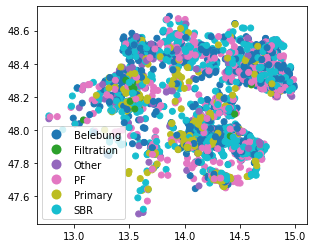

In [132]:
gdf.plot(column='tech_type',legend=True)

In [133]:
with open('final/oebo_points.shp', 'w') as f:
    f.write(gdf.to_json())

# unify 

In [134]:
oebo=gdf

In [135]:
noe=gpd.read_file('final/noe_points.shp')


In [136]:
noe.reset_index(drop=True)

,geometry


In [137]:
noe['BL']='Lower-Austria'
oebo['BL']='Upper-Austria'

In [138]:
gdf_list=[noe,oebo]
both= gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True), crs=gdf_list[0].crs)

In [139]:
data=both

In [140]:
data[['tech_type','no_nitri']].value_counts()

tech_type   no_nitri
SBR         False       920
Belebung    False       692
PF          False       555
Primary     True        310
Other       nd          132
Filtration  True         24
dtype: int64

In [141]:
#data.value_counts(['bautyp','tech_type'])
#data.value_counts(['tech_type','bautyp'])

In [142]:
rep={'Bel.':'Belebung','n.d.':'nd','n.d.':'nd',}

In [143]:
data.tech_type=data.tech_type.replace(rep)

In [144]:
rep={'Belebung':'ASP','Tropf':'TRF','PF':'CW','PKA':'CW','Filtration':'FLTR'}
data.tech_type=data.tech_type.replace(rep)


In [145]:
#data=data[['id', 'BEZIRK', 'NAME', 'PE', 'bautyp','tech_type','no_nitri', 'year',
       #'geometry','BL']]

In [146]:

data.groupby('no_nitri').count()

,geometry,BL,NAME,PE,year,tech_type,nitri
no_nitri,,,,,,,
False,2167,2167,2167,2167,2167,2167,2167
True,334,334,334,334,334,334,334
nd,132,132,132,132,132,132,132


In [147]:
data.replace({'True':True,'False':False},inplace=True)

In [148]:
data.loc[data.tech_type == 'Primary' , 'bautyp'] = 'Mech'
data.loc[data.tech_type == 'SBR' , 'bautyp'] = 'Bio'
data.loc[data.tech_type == 'CW' , 'bautyp'] = 'Bio'
data.loc[data.tech_type == 'RBC', 'bautyp'] = 'Bio'
data.loc[data.tech_type == 'BKF', 'bautyp'] = 'Bio'
data.loc[data.tech_type == 'TRF', 'bautyp'] = 'Bio'
data.loc[data.tech_type == 'ASP', 'bautyp'] = 'Bio'

In [149]:
data.no_nitri.value_counts()

False    2167
True      334
nd        132
Name: no_nitri, dtype: int64

In [150]:
#data[['tech_type','bautyp']].value_counts()
#data[['bautyp','no_nitri']].value_counts()

In [151]:
# replace FLTR and CMPST with extra cetegory
data.loc[data.no_nitri == 'False', 'no_nitri'] = False
data.loc[data.no_nitri == 'True', 'no_nitri'] = True
data.loc[data.tech_type == 'FLTR', 'tech_type'] = 'Filtration'



In [152]:
data.loc[data.tech_type == 'TRF', 'no_nitri'] = True
data.loc[data.tech_type == 'Primary', 'no_nitri'] = True
data.loc[data.bautyp == 'Mech', 'no_nitri'] = True
data.loc[data.bautyp == 'Bio', 'no_nitri'] = False

In [153]:
with open('final/noe_oebo_points2.geojson', 'w') as f:
    f.write(data.to_json())

<AxesSubplot:>

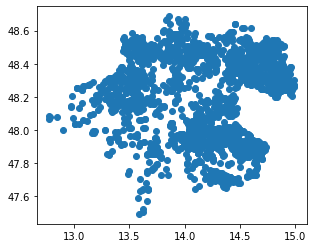

In [154]:
data.plot()

In [155]:
data[(data.no_nitri==True)&(data.year>1990)]

,geometry,BL,NAME,PE,year,tech_type,nitri,no_nitri,bautyp
255,POINT (14.13154 47.80530),Upper-Austria,LAWOG Steyrling I,36.0,1995.0,Filtration,1.0,True,NaN
516,POINT (14.02401 48.40281),Upper-Austria,Rechberger Willnauer,20.0,2015.0,Primary,1.0,True,Mech
541,POINT (14.49629 47.99453),Upper-Austria,Badhofer,20.0,1992.0,Filtration,1.0,True,NaN
1031,POINT (14.12581 47.95666),Upper-Austria,Vierthaler Bernhard und Margarete,10.0,1995.0,Filtration,1.0,True,NaN
1344,POINT (14.11456 48.01685),Upper-Austria,Gruber Alois und Theresia,8.0,1991.0,Filtration,0.0,True,NaN
1646,POINT (14.49827 47.99021),Upper-Austria,Badhofer Susanne,8.0,2019.0,Primary,0.0,True,Mech
1766,POINT (14.55770 48.43298),Upper-Austria,Hofreiter Günter,6.0,2017.0,Primary,1.0,True,Mech
1835,POINT (14.04539 47.96642),Upper-Austria,Brunmair Karl u. Ilse,6.0,1991.0,Primary,0.0,True,Mech
1997,POINT (14.45226 48.09501),Upper-Austria,Schartlmüller Anton und Edith,6.0,2005.0,Filtration,1.0,True,NaN
2006,POINT (14.56191 47.90195),Upper-Austria,Großauer Christina und Rupert,6.0,2017.0,Primary,1.0,True,Mech


In [156]:
from functions import logical_column
conditions=[
    data.tech_type=='SBR',
    data.tech_type=='PKA',
    data.tech_type=='Belebung',
    data.tech_type=='PF',
    data.tech_type=='Primary',
    data.tech_type=='nd',
    data.tech_type=='Other',
    data.tech_type=='BKF',
    data.tech_type=='Tropf',
    data.tech_type=='Filtration',
    data.tech_type=='Fest',
    data.tech_type=='RBC',
    data.tech_type=='MBR',


]

outcome=[False,False,False,False,True,'nd',False,False,False,True,False,False,False]
data=logical_column(conditions,outcome,data,'new')

nd=data[data.tech_type=='nd']
data=data[data.tech_type!='nd']
nd.loc[nd.bautyp=='Bio', 'no_nitri'] = False
nd.loc[nd.bautyp=='Mech', 'no_nitri'] = True


# what had no coordinates?

In [157]:
no_geo.groupby('bautyp').count()
no_geo.groupby('tech_type').count()
no_geo.groupby('BEZIRK').count()

,Unnamed: 0,NAME,EW60,INBETRIEBNAHME,RECHTSWERT,HOCHWERT,bautyp,tech_type,activity,before_reg,no_nitri
BEZIRK,,,,,,,,,,,
Amstetten,704,704,704,704,0,0,704,704,704,704,704
